## Stock Price Prediction using XGBoost and ARIMAX with Feature Engineering & Hyperparameter Tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, RidgeCV
from pmdarima.arima import auto_arima
from pandas_datareader import data as pdr
import yfinance as yf
import itertools
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configure Yahoo Finance data source
# Download historical stock data
ticker = "GOOGL"
start_date = "2018-01-01"
end_date = "2023-10-31"

df = yf.download(ticker, start=start_date, end=end_date, progress=False)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000
...,...,...,...,...,...,...
2023-10-24,137.830002,139.360001,137.419998,138.809998,138.809998,44814300
2023-10-25,128.160004,128.309998,125.070000,125.610001,125.610001,84366200
2023-10-26,123.269997,124.330002,121.269997,122.279999,122.279999,57061100


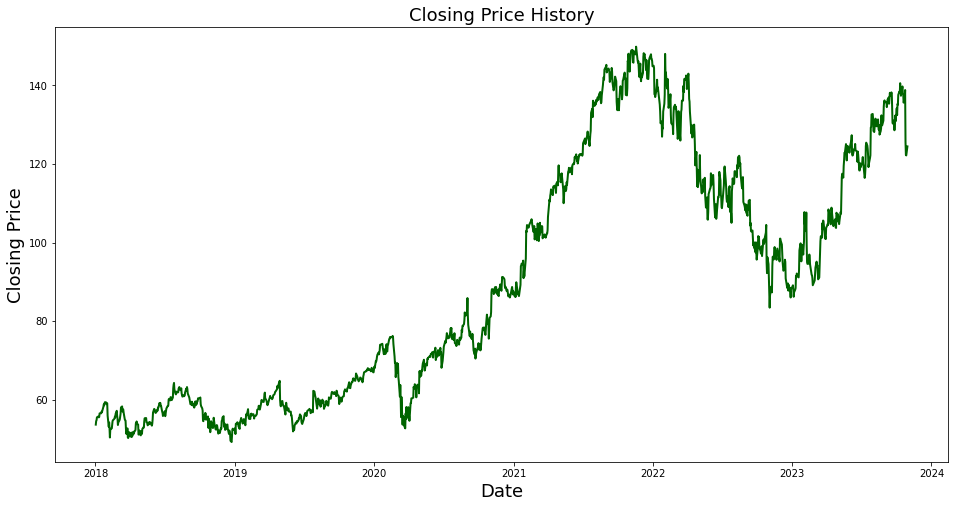

In [3]:
# Plot the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History', fontsize=18)
plt.plot(df['Close'], linewidth=2, color='Darkgreen')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.show()

In [4]:
# Feature Engineering
df['Return'] = df['Close'].pct_change() # Simple daily return
df['Moving_Avg_5'] = df['Close'].rolling(window=5).mean() # 5-day moving average
df['Moving_Avg_10'] = df['Close'].rolling(window=10).mean() # 10-day moving average
df['Moving_STD_10'] = df['Close'].rolling(window=10).std() # 10-day moving standard deviation

# Replace NA values with 0
df.fillna(0, inplace=True)

df.head(30)

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000,0.000000,0.000000,0.000000,0.000000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000,0.017061,0.000000,0.000000,0.000000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000,0.003884,0.000000,0.000000,0.000000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000,0.013260,0.000000,0.000000,0.000000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000,0.003531,54.849899,0.000000,0.000000
2018-01-09,55.922001,55.922001,55.410000,55.639500,55.639500,26808000,-0.001274,55.245699,0.000000,0.000000
2018-01-10,55.349998,55.639000,55.199001,55.507000,55.507000,20734000,-0.002381,55.431899,0.000000,0.000000
2018-01-11,55.615501,55.742500,55.324001,55.602501,55.602501,22424000,0.001721,55.594800,0.000000,0.000000
2018-01-12,55.505001,56.564999,55.400501,56.532501,56.532501,38586000,0.016726,55.798400,0.000000,0.000000


In [5]:
# Removing first 9 rows since they contain 0 values
df1 = df[9:]

df1.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-16,57.015499,57.444000,56.3330,56.535000,56.535000,36462000,0.000044,55.963300,55.40660,0.873630
2018-01-17,56.818001,56.966000,56.1745,56.955002,56.955002,27830000,0.007429,56.226401,55.73605,0.755158
2018-01-18,56.967499,57.029499,56.2230,56.798500,56.798500,27498000,-0.002748,56.484701,55.95830,0.700913
2018-01-19,56.901501,57.188999,56.6250,57.174999,57.174999,30552000,0.006629,56.799200,56.19700,0.663533
2018-01-22,57.191002,58.344002,57.0910,58.208000,58.208000,29550000,0.018067,57.134300,56.46635,0.870204


In [6]:
# Define the features and the target variable
features = ['Open', 'High', 'Low', 'Return', 'Moving_Avg_5', 'Moving_Avg_10', 'Moving_STD_10']

X = df1[features]
y = df1['Close']

# Feature Scaling
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1,1))

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42)

In [8]:
# Use auto_arima to find the best model for the data
stepwise_model = auto_arima(y_train,
                            exogenous = X_train,
                            start_p=1, start_q=1,
                            max_p=3, max_q=3,
                            m=12, start_P=0, seasonal=False,
                            d=1, D=1, trace=True,
                            error_action='ignore', suppress_warnings=True,
                            stepwise=True)

# Fit ARIMAX model
best_arimax_model = SARIMAX(y_train,
                exog = X_train,
                order=stepwise_model.order)
best_arimax_fit = best_arimax_model.fit(disp=False)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6198.781, Time=0.17 sec


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6193.752, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6199.065, Time=0.44 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6198.784, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6194.961, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6197.599, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6195.494, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6200.138, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-6198.713, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6199.899, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6199.851, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-6197.900, Time=0.37 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.814 seconds


In [9]:
# Make predictions
arimax_predictions = best_arimax_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

In [10]:
# Denormalize predictions
arimax_pred_inv = target_scaler.inverse_transform(np.array(arimax_predictions).reshape(-1, 1))

# Denormalize original test_data
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

In [11]:
# Calculate Evaluation Metrics for ARIMA model
arimax_mse = mean_squared_error(y_test_inv, arimax_pred_inv)
arimax_rmse = np.sqrt(arimax_mse)    
arimax_mae = mean_absolute_error(y_test_inv, arimax_pred_inv)
arimax_r2 = r2_score(y_test_inv, arimax_pred_inv)

print("ARIMAX Model Evaluation Metrics")
print("-------------------------------")
print('MSE: {:.4f}'.format(arimax_mse))
print('RMSE: {:.4f}'.format(arimax_rmse))
print('MAE: {:.4f}'.format(arimax_mae))
print('R2: {:.4f}'.format(arimax_r2))

ARIMAX Model Evaluation Metrics
-------------------------------
MSE: 0.8467
RMSE: 0.9202
MAE: 0.7725
R2: 0.9968


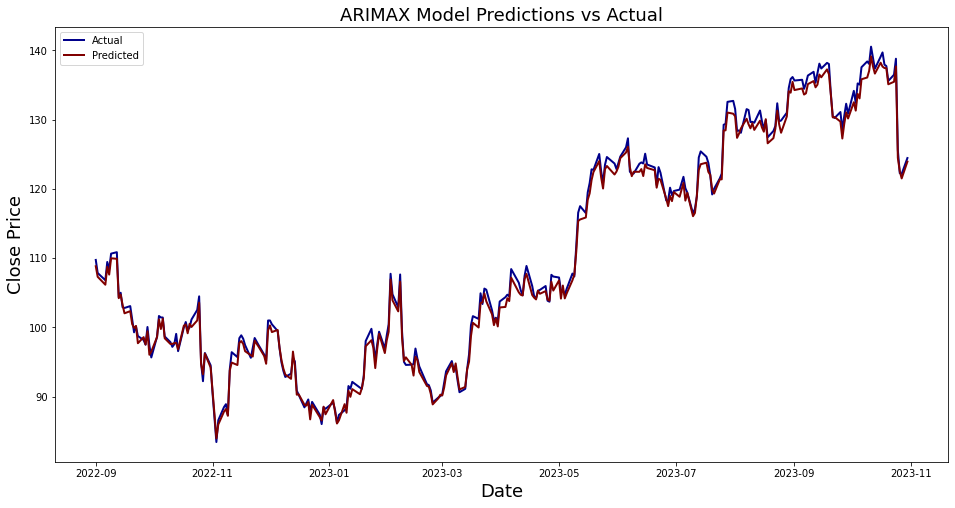

In [12]:
# Plot the predictions of LSTM model without Hyperparameter tuning
plt.figure(figsize=(16,8))
plt.title('ARIMAX Model Predictions vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual')
plt.plot(df1.index[-len(y_test):], arimax_pred_inv, linewidth=2, color='maroon', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

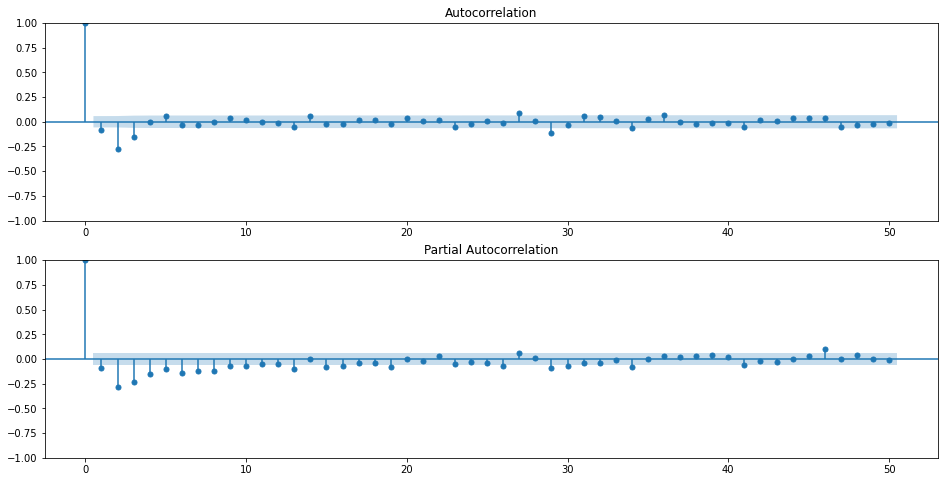

In [13]:
# ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,8))
plot_acf(best_arimax_fit.resid, lags=50, ax=ax1)
plot_pacf(best_arimax_fit.resid, lags=50, ax=ax2)
plt.show()

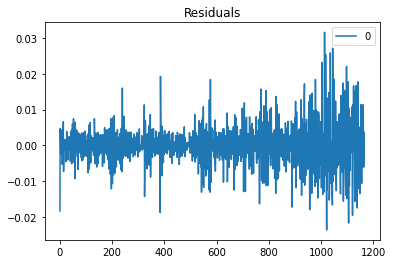

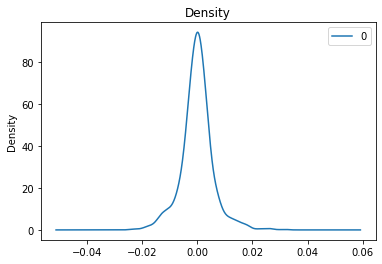

<Figure size 1152x720 with 0 Axes>

In [14]:
# Residual Errors
residuals = pd.DataFrame(best_arimax_fit.resid)
residuals.plot(title="Residuals")
residuals.plot(kind='kde', title='Density')
plt.figure(figsize=(16,10))
plt.show()

In [15]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1166, 7)
y_train shape:  (1166, 1)
X_test shape:  (292, 7)
y_test shape:  (292, 1)


In [16]:
# XGBoost Regressor Model without Hyperparameter Tuning
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

# Denormalize the predicted values
pred_xgb_inv = target_scaler.inverse_transform(pred_xgb.reshape(-1,1))
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1,1))

In [17]:
# Calculate the evaluation metrics for XGBoost Regressor
xgb_mse = mean_squared_error(y_test_inv, pred_xgb_inv)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test_inv, pred_xgb_inv)
xgb_mae = mean_absolute_error(y_test_inv, pred_xgb_inv)

print('XGBoost Regressor Evaluation Metrics')
print('MSE: {:.4f}'.format(xgb_mse))
print('RMSE: {:.4f}'.format(xgb_rmse))
print('MAE: {:.4f}'.format(xgb_mae))
print('R2: {:.4f}'.format(xgb_r2))

XGBoost Regressor Evaluation Metrics
MSE: 1.8261
RMSE: 1.3513
MAE: 0.9734
R2: 0.9930


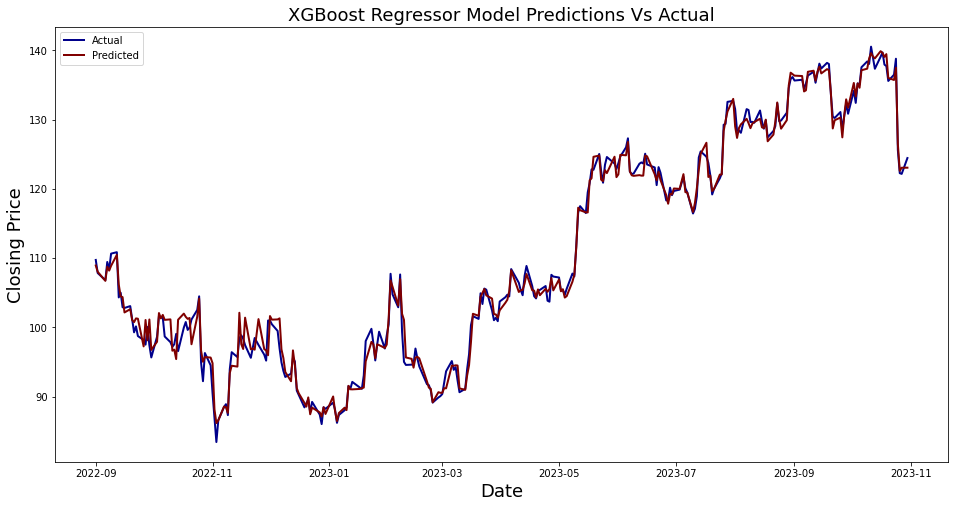

In [18]:
# Plot the predicted values against the actual values
plt.figure(figsize=(16,8))
plt.title('XGBoost Regressor Model Predictions Vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_xgb_inv, linewidth=2, color='maroon', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

In [19]:
# Stacked XGB-ARIMAX Model
stacked_predictions = np.column_stack((arimax_predictions, pred_xgb))

# Train a final regressor based on the stacked predictions
final_regressor = LinearRegression().fit(stacked_predictions, y_test)

# Predict on the test data
final_pred = final_regressor.predict(stacked_predictions)

# Denormalize the predicted values
final_pred_inv = target_scaler.inverse_transform(final_pred.reshape(-1,1))

In [20]:
# Calculate the Evaluation Metrics for Stacked model
final_mse = mean_squared_error(y_test_inv, final_pred_inv)
final_rmse = np.sqrt(mean_squared_error(y_test_inv, final_pred_inv))
final_mae = mean_absolute_error(y_test_inv, final_pred_inv)
final_r2 = r2_score(y_test_inv, final_pred_inv)

print("XGBoost-ARIMAX Model Evaluation Metrics")
print("=======================================")
print("MSE: {:.4f}".format(final_mse))
print("RMSE: {:.4f}".format(final_rmse))
print("MAE: {:.4f}".format(final_mae))
print("R2: {:.4f}".format(final_r2))

XGBoost-ARIMAX Model Evaluation Metrics
MSE: 0.3597
RMSE: 0.5997
MAE: 0.4808
R2: 0.9986


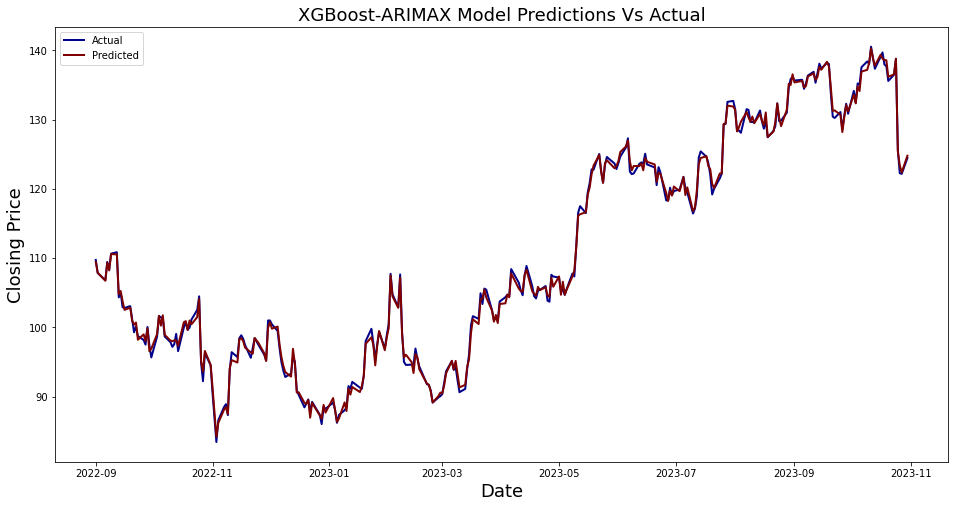

In [21]:
# Plot the predicted values against the actual values
plt.figure(figsize=(16,8))
plt.title('XGBoost-ARIMAX Model Predictions Vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual')
plt.plot(df1.index[-len(y_test):], final_pred_inv, linewidth=2, color='maroon', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

In [22]:
# XGB model with Hyperparameter tuning
# Define the parameter grid
param_grid = {'n_estimators': [100, 200, 300],
                'max_depth': [3, 4, 5, 10, 15, 20],
                'learning_rate': [0.01, 0.05, 0.1],
                'colsample_bytree': [0.3, 0.5, 0.7],
                'gamma': [0, 0.1, 0.2]}

# Grid search on XGB
grid1 = GridSearchCV(XGBRegressor(), param_grid, cv=5, n_jobs=-1, verbose=True)
grid_xgb = grid1.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found: ", grid_xgb.best_params_)
print("Best score: ", grid_xgb.best_score_)
# print("Best estimator: ", grid_xgb.best_estimator_)

# Using best estimator for xgb model from the grid search
best_xgb_model = grid_xgb.best_estimator_

# Predictions
pred_best_xgb = best_xgb_model.predict(X_test)

# Inverse transform the predictions
pred_best_xgb_inv = target_scaler.inverse_transform(pred_best_xgb.reshape(-1, 1))

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best parameters found:  {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
Best score:  0.9729029346752484


In [23]:
# Calculate the evaluation metrics for XGBoost Regressor
xgb_tuned_mse = mean_squared_error(y_test_inv, pred_best_xgb_inv)
xgb_tuned_rmse = np.sqrt(xgb_tuned_mse)
xgb_tuned_r2 = r2_score(y_test_inv, pred_best_xgb_inv)
xgb_tuned_mae = mean_absolute_error(y_test_inv, pred_best_xgb_inv)

print('Tuned XGBoost Regressor Evaluation Metrics')
print('MSE: {:.4f}'.format(xgb_tuned_mse))
print('RMSE: {:.4f}'.format(xgb_tuned_rmse))
print('MAE: {:.4f}'.format(xgb_tuned_mae))
print('R2 Score: {:.4f}'.format(xgb_tuned_r2))

Tuned XGBoost Regressor Evaluation Metrics
MSE: 1.0999
RMSE: 1.0487
MAE: 0.7875
R2 Score: 0.9958


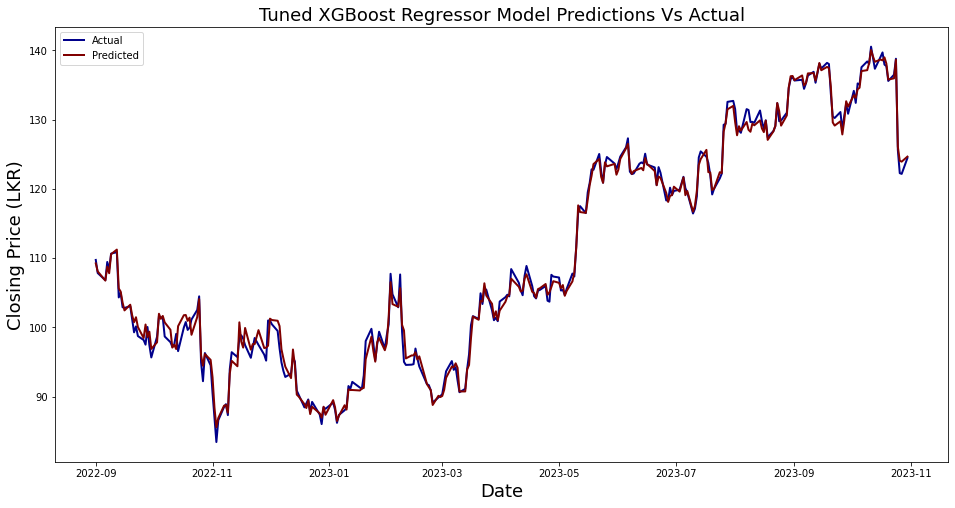

In [24]:
# Plot the predicted values against the actual values
plt.figure(figsize=(16,8))
plt.title('Tuned XGBoost Regressor Model Predictions Vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_best_xgb_inv, linewidth=2, color='maroon', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price (LKR)', fontsize=18)
plt.legend()
plt.show()

In [25]:
# Stacked XGB-ARIMAX Model with Hyperparameter Tuning
stacked_predictions_tuned_2 = np.column_stack((arimax_predictions, pred_best_xgb))

# Train a final regressor based on the stacked predictions
final_regressor_tuned_2 = LinearRegression().fit(stacked_predictions_tuned_2, y_test)

# Predict on the test data
final_pred_tuned_2 = final_regressor_tuned_2.predict(stacked_predictions_tuned_2)

# Denormalize the predicted values
final_pred_tuned_2_inv = target_scaler.inverse_transform(final_pred_tuned_2.reshape(-1,1))

In [26]:
# Calculate the Evaluation Metrics for Stacked model
final_tuned_mse_2 = mean_squared_error(y_test_inv, final_pred_tuned_2_inv)
final_tuned_rmse_2 = np.sqrt(mean_squared_error(y_test_inv, final_pred_tuned_2_inv))
final_tuned_mae_2 = mean_absolute_error(y_test_inv, final_pred_tuned_2_inv)
final_tuned_r2_2 = r2_score(y_test_inv, final_pred_tuned_2_inv)

print("Tuned XGBoost-ARIMAX Model Evaluation Metrics")
print("=============================================")
print("MSE: {:.4f}".format(final_tuned_mse_2))
print("RMSE: {:.4f}".format(final_tuned_rmse_2))
print("MAE: {:.4f}".format(final_tuned_mae_2))
print("R2: {:.4f}".format(final_tuned_r2_2))

Tuned XGBoost-ARIMAX Model Evaluation Metrics
MSE: 0.3582
RMSE: 0.5985
MAE: 0.4806
R2: 0.9986


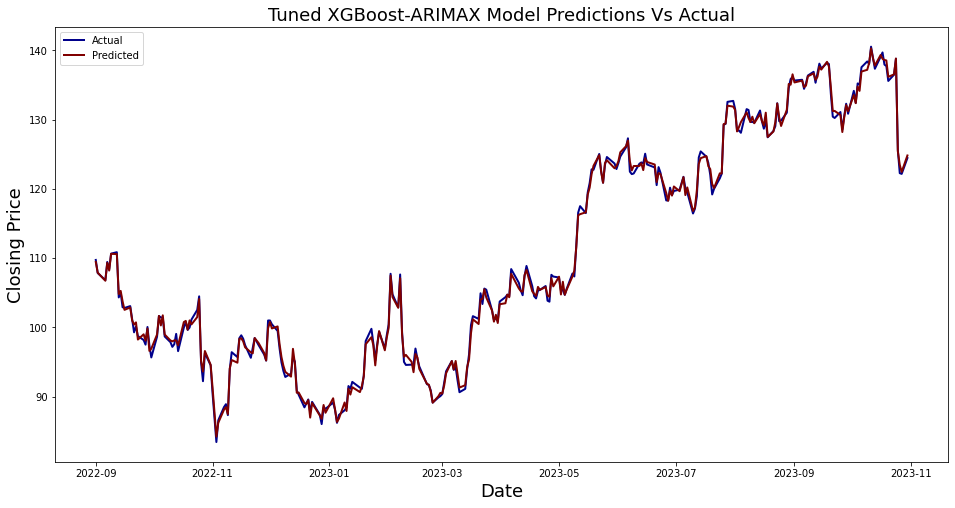

In [27]:
# Plot the predicted values against the actual values
plt.figure(figsize=(16,8))
plt.title('Tuned XGBoost-ARIMAX Model Predictions Vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkblue', label='Actual')
plt.plot(df1.index[-len(y_test):], final_pred_tuned_2_inv, linewidth=2, color='maroon', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.legend()
plt.show()

In [28]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

# Predict using the XGB model
predicted_prices_xgb = []

last_features_xgb = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_xgb = xgb.predict(last_features_xgb)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_xgb = predicted_price_xgb.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_xgb = target_scaler.inverse_transform(predicted_price_reshaped_xgb)[0][0]
    predicted_prices_xgb.append(inverse_transformed_price_xgb)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_xgb = np.array([
        last_features_xgb[0, 1], 
        last_features_xgb[0, 2], 
        predicted_price_reshaped_xgb[0, 0], 
        (predicted_price_reshaped_xgb[0, 0] - last_features_xgb[0, 3]) / last_features_xgb[0, 3],
        np.mean(np.append(last_features_xgb[0, 4:6], predicted_price_reshaped_xgb[0, 0])),
        np.mean(np.append(last_features_xgb[0, 5:], predicted_price_reshaped_xgb[0, 0])),
        np.std(np.append(last_features_xgb[0, 6:], predicted_price_reshaped_xgb[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_xgb = new_features_xgb

print("\nPredicted Closing Prices for the Next 2 Days (XGB Model):")
for i, price in enumerate(predicted_prices_xgb):
    print(f"Day {i+1}:" "{:.3f}".format(price))


Predicted Closing Prices for the Next 2 Days (XGB Model):
Day 1:123.066
Day 2:119.455


In [29]:
last_features = X_scaled[-1:]

# Predict stock prices using the ARIMAX model for the next 2 days
last_features_arimax = last_features.copy()

future_exog_day1 = last_features_arimax.copy()
future_exog_day2 = last_features_arimax.copy()  # Modify this with estimated values for day 2

# Combine the exogenous variables for both days
future_exog = np.vstack([future_exog_day1, future_exog_day2])

# Forecast the next 2 days
forecasted_prices_arimax = best_arimax_fit.forecast(steps=2, exog=future_exog)

# Convert the forecasted prices to a NumPy array and then reshape
forecasted_prices_arimax_np = np.array(forecasted_prices_arimax)
forecasted_prices_arimax_reshaped = forecasted_prices_arimax_np.reshape(-1, 1)

# Inverse transform the forecasted prices
forecasted_prices_arimax_inv = target_scaler.inverse_transform(forecasted_prices_arimax_reshaped)

# Print the predicted prices for the next 2 days
print("Predicted Closing Prices for the Next 2 Days (ARIMAX Model):")
for i, price in enumerate(forecasted_prices_arimax_inv):
    print(f"Day {i+1}: {price[0]:.3f}")

Predicted Closing Prices for the Next 2 Days (ARIMAX Model):
Day 1: 124.015
Day 2: 123.919


In [30]:
last_features = X_scaled[-1:]

# Predict using the XGB model
predicted_prices_xgb = []

last_features_xgb = last_features.copy()

for _ in range(2):
    # Predicting the next day stock price using the last feature data
    predicted_price_xgb = best_xgb_model.predict(last_features_xgb)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped_xgb = predicted_price_xgb.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price_xgb = target_scaler.inverse_transform(predicted_price_reshaped_xgb)[0][0]
    predicted_prices_xgb.append(inverse_transformed_price_xgb)

    # Computing new features based on the predicted price
    # Here we reuse the logic for LSTM for simplicity. Depending on the scenario, the exact methodology might change.
    new_features_xgb = np.array([
        last_features_xgb[0, 1], 
        last_features_xgb[0, 2], 
        predicted_price_reshaped_xgb[0, 0], 
        (predicted_price_reshaped_xgb[0, 0] - last_features_xgb[0, 3]) / last_features_xgb[0, 3],
        np.mean(np.append(last_features_xgb[0, 4:6], predicted_price_reshaped_xgb[0, 0])),
        np.mean(np.append(last_features_xgb[0, 5:], predicted_price_reshaped_xgb[0, 0])),
        np.std(np.append(last_features_xgb[0, 6:], predicted_price_reshaped_xgb[0, 0]))
    ], dtype=np.float32).reshape(1, 7)

    last_features_xgb = new_features_xgb

print("\nPredicted Closing Prices for the Next 2 Days (Best XGB Model):")
for i, price in enumerate(predicted_prices_xgb):
    print(f"Day {i+1}:" "{:.3f}".format(price))


Predicted Closing Prices for the Next 2 Days (Best XGB Model):
Day 1:124.667
Day 2:123.846


In [31]:
last_features = X_scaled[-1:]

# Predict stock prices using the Stacked model for the next 2 days
predicted_prices_stacked = []

last_features_stacked = last_features.copy()

future_exog_day1 = last_features_arimax.copy()
future_exog_day2 = last_features_arimax.copy()
future_exog_data = [future_exog_day1, future_exog_day2]

for i in range(2):
    # Predict using XGBoost
    xgb_pred = best_xgb_model.predict(last_features)

    # Debugging: Print the shape and type of exogenous data for ARIMAX
    #print(f"Exogenous data for day {i+1}, Type: {type(future_exog_data[i])}, Shape: {future_exog_data[i].shape if isinstance(future_exog_data[i], np.ndarray) else future_exog_data[i].shape}")

    # Predict using ARIMAX
    arimax_pred = best_arimax_fit.forecast(steps=1, exog=future_exog_data[i])

    # Combine XGBoost and ARIMAX predictions
    combined_pred = np.column_stack([xgb_pred, arimax_pred])

    # Predict using the final regressor
    final_pred = final_regressor_tuned_2.predict(combined_pred)

    # Reshape the predicted price for inverse scaling
    combined_pred = combined_pred.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(final_pred.reshape(-1, 1))[0][0]
    predicted_prices_stacked.append(inverse_transformed_price)

print("Predicted Closing Prices for the Next 2 Days (XGBoost-ARIMAX Stacked Model):")
for i, price in enumerate(predicted_prices_stacked):
    print(f"Day {i+1}: {price:.3f}")

Predicted Closing Prices for the Next 2 Days (XGBoost-ARIMAX Stacked Model):
Day 1: 125.491
Day 2: 125.491
